# Project on data jobs

## Importing Liberaries

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import re


## Laoding Data 

In [2]:
df = pd.read_csv(r'Data/Raw/data_jobs.csv')

In [3]:
df.job_skills.value_counts()

job_skills
['excel']                                                                                                                                                                                                 13238
['sql']                                                                                                                                                                                                   11732
['python']                                                                                                                                                                                                 8509
['python', 'sql']                                                                                                                                                                                          4753
['sql', 'excel']                                                                                                                                             

In [4]:
df.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
449591,Senior Data Analyst,Data Analyst Ssr,Argentina,via LinkedIn,Full-time,False,Argentina,2023-07-14 14:22:06,True,False,Argentina,NaN,NaN,NaN,VMLY&R,"['sql', 'python', 'html', 'power bi', 'looker'...","{'analyst_tools': ['power bi', 'looker', 'tabl..."
706952,Software Engineer,Entry Level Programmer/Coder/Developer/Data...,"Charlotte, NC",via Snagajob,Full-time,False,Georgia,2023-07-15 02:54:23,False,False,United States,NaN,NaN,NaN,SynergisticIT,"['go', 'java', 'javascript', 'c++', 'sas', 'sa...","{'analyst_tools': ['sas', 'tableau'], 'librari..."
448999,Data Scientist,Data Scientist,"Warsaw, Poland",via SmartRecruiters Job Search,Full-time,False,Poland,2023-05-04 14:24:21,False,False,Poland,NaN,NaN,NaN,NielsenIQ,"['python', 'r', 'sql']","{'programming': ['python', 'r', 'sql']}"


In [5]:
df.shape

(785741, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   job_title_short        785741 non-null  object 
 1   job_title              785740 non-null  object 
 2   job_location           784696 non-null  object 
 3   job_via                785733 non-null  object 
 4   job_schedule_type      773074 non-null  object 
 5   job_work_from_home     785741 non-null  bool   
 6   search_location        785741 non-null  object 
 7   job_posted_date        785741 non-null  object 
 8   job_no_degree_mention  785741 non-null  bool   
 9   job_health_insurance   785741 non-null  bool   
 10  job_country            785692 non-null  object 
 11  salary_rate            33067 non-null   object 
 12  salary_year_avg        22003 non-null   float64
 13  salary_hour_avg        10662 non-null   float64
 14  company_name           785723 non-nu

In [7]:
df.job_schedule_type.nunique()

47

In [8]:
df['num_jobs'] = 1

## Mapping values in columns

In [9]:
job_title_mapping = {
    'Senior Data Analyst': 'Data Analyst',
    'Senior Data Scientist': 'Data Scientist',
    'Senior Data Engineer': 'Data Engineer'
}

# Apply the mapping to the 'job_title_short' column
df['job_title_short'] = df['job_title_short'].replace(job_title_mapping)

# Display the updated DataFrame to verify the changes
print(df['job_title_short'].value_counts())


job_title_short
Data Engineer                230804
Data Analyst                 225291
Data Scientist               209243
Business Analyst              49063
Software Engineer             44929
Machine Learning Engineer     14080
Cloud Engineer                12331
Name: count, dtype: int64


In [10]:

# Fill null values in 'job_schedule_type' with the mode (most frequent value)
mode_job_schedule_type = df['job_schedule_type'].mode()
if not mode_job_schedule_type.empty:
    df['job_schedule_type'] = df['job_schedule_type'].fillna(mode_job_schedule_type[0])


# Define replacement patterns
replacements = {
    r'\bfull[-\s]?time\b': 'Full-time',      # Match "full time", "full-time", "full time ", etc.
    r'\bpart[-\s]?time\b': 'Part-time',      # Match "part time", "part-time", "part time ", etc.
    r'\bcontractor\b': 'Contract',           # Match "contractor" in any case
    r'\binternship\b': 'Internship',         # Match "internship" in any case
}

# Create a function to apply replacements using regex
def replace_job_schedule_type(text):
    for pattern, replacement in replacements.items():
        if re.search(pattern, text, re.IGNORECASE):
            return replacement
    return 'Others'  # Default category if no pattern matches

# Apply the function to the 'job_schedule_type' column
df['job_schedule_type'] = df['job_schedule_type'].apply(replace_job_schedule_type)

df['job_schedule_type'].value_counts()

job_schedule_type
Full-time     728910
Contract       37124
Internship      8955
Part-time       8450
Others          2302
Name: count, dtype: int64

In [11]:
df_sorted = df.sort_values(by='job_posted_date')

# Get the first and last values of the sorted column
first_value = df_sorted['job_posted_date'].iloc[0]
last_value = df_sorted['job_posted_date'].iloc[-1]

print("First value:", first_value)
print("Last value:", last_value)

First value: 2023-01-01 00:00:04
Last value: 2023-12-31 23:59:58


## Cleaning and Processing

In [12]:


# Calculate the mean salary for each combination of job title and country
mean_salaries = df.groupby(['job_title_short', 'job_country'])['salary_year_avg'].mean().reset_index()
mean_salaries.rename(columns={'salary_year_avg': 'mean_salary'}, inplace=True)

# Merge the mean salaries back to the original DataFrame
df = df.merge(mean_salaries, on=['job_title_short', 'job_country'], how='left')

# Fill NaNs in salary_year_avg with the mean_salary based on job_title_short and job_country
df['salary_year_avg'] = df['salary_year_avg'].fillna(df['mean_salary'])

# Drop the mean_salary column as it's no longer needed
df.drop(columns=['mean_salary'], inplace=True)

# Check for any remaining NaN values
if df['salary_year_avg'].isnull().any():
    # Calculate the mean salary for each job title (ignoring country)
    mean_salaries_job_title = df.groupby('job_title_short')['salary_year_avg'].mean().reset_index()
    mean_salaries_job_title.rename(columns={'salary_year_avg': 'mean_salary'}, inplace=True)

    # Merge these mean salaries back to the original DataFrame
    df = df.merge(mean_salaries_job_title, on='job_title_short', how='left')

    # Fill the remaining NaNs in salary_year_avg with the mean_salary based on job_title_short
    df['salary_year_avg'] = df['salary_year_avg'].fillna(df['mean_salary'])

    # Drop the mean_salary column as it's no longer needed
    df.drop(columns=['mean_salary'], inplace=True)



In [13]:
df['salary_year_avg'].isnull().sum()

0

In [14]:
# Remove rows where all columns are NaN
df_cleaned = df.dropna(how='all')

# Optionally, reset the index if you want to reindex the DataFrame
df_cleaned = df_cleaned.reset_index(drop=True)

In [15]:
df_cleaned.shape

(785741, 18)

In [16]:

# Filter rows where 'job_country' is not null
df_filtered = df[df['job_country'].notna()]


# Remove rows where all other columns (except 'job_country') are null
df_cleaned = df_filtered.dropna(how='all', subset=df_filtered.columns.difference(['job_country']))

# Drop columns 'salary_rate' and 'salary_hour_avg'
df_cleaned = df_cleaned.drop(columns=['salary_rate', 'salary_hour_avg'])

# Fill null values in 'job_via' with 'Other'
df_cleaned['job_via'] = df_cleaned['job_via'].fillna('Other')

# Fill null values in 'job_location' with 'Anywhere'
df_cleaned['job_location'] = df_cleaned['job_location'].fillna('Anywhere')


# Fill null values in 'job_skills' with 'Not specified'
df_cleaned['job_skills'] = df_cleaned['job_skills'].fillna('Not specified')

# Fill null values in 'company_name' with 'Not specified'
df_cleaned['company_name'] = df_cleaned['company_name'].fillna('Not specified')

# Fill null values in 'job_skills' with 'Not specified'
df_cleaned['job_type_skills'] = df_cleaned['job_type_skills'].fillna('Not specified')

# Optionally, reset the index if you want to reindex the DataFrame
df_cleaned = df_cleaned.reset_index(drop=True)



In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785692 entries, 0 to 785691
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   job_title_short        785692 non-null  object 
 1   job_title              785692 non-null  object 
 2   job_location           785692 non-null  object 
 3   job_via                785692 non-null  object 
 4   job_schedule_type      785692 non-null  object 
 5   job_work_from_home     785692 non-null  bool   
 6   search_location        785692 non-null  object 
 7   job_posted_date        785692 non-null  object 
 8   job_no_degree_mention  785692 non-null  bool   
 9   job_health_insurance   785692 non-null  bool   
 10  job_country            785692 non-null  object 
 11  salary_year_avg        785692 non-null  float64
 12  company_name           785692 non-null  object 
 13  job_skills             785692 non-null  object 
 14  job_type_skills        785692 non-nu

In [18]:
df_cleaned.isnull().sum()

job_title_short          0
job_title                0
job_location             0
job_via                  0
job_schedule_type        0
job_work_from_home       0
search_location          0
job_posted_date          0
job_no_degree_mention    0
job_health_insurance     0
job_country              0
salary_year_avg          0
company_name             0
job_skills               0
job_type_skills          0
num_jobs                 0
dtype: int64

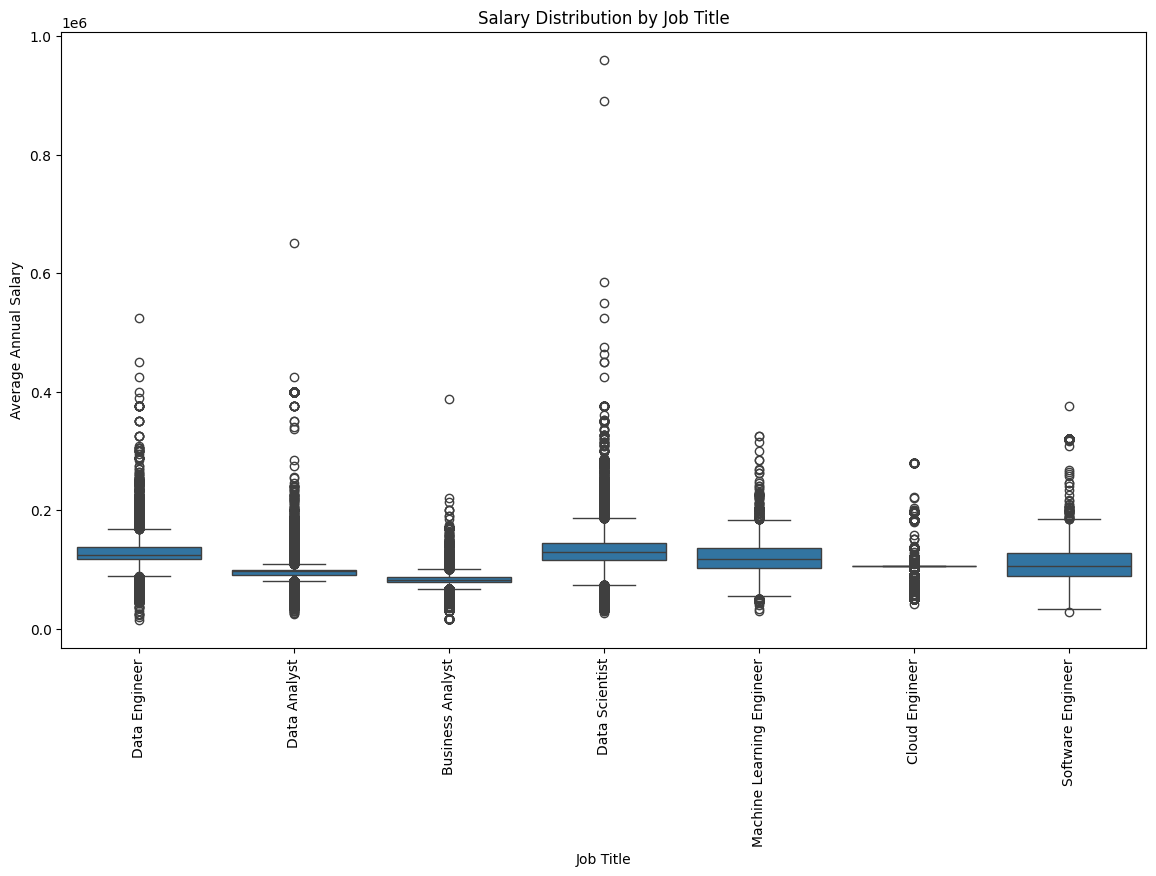

In [19]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='job_title_short', y='salary_year_avg', data=df_cleaned)
plt.xticks(rotation=90)
plt.xlabel('Job Title')
plt.ylabel('Average Annual Salary')
plt.title('Salary Distribution by Job Title')
plt.show()


In [20]:
import pandas as pd

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each job title in df_cleaned
Q1_cleaned = df_cleaned.groupby('job_title_short')['salary_year_avg'].quantile(0.25)
Q3_cleaned = df_cleaned.groupby('job_title_short')['salary_year_avg'].quantile(0.75)
IQR_cleaned = Q3_cleaned - Q1_cleaned  # Interquartile Range for df_cleaned

# Define a function to filter out outliers based on the IQR for df_cleaned
def remove_outliers_cleaned(group):
    lower_bound = Q1_cleaned[group.name] - 1.5 * IQR_cleaned[group.name]
    upper_bound = Q3_cleaned[group.name] + 1.5 * IQR_cleaned[group.name]
    return group[(group['salary_year_avg'] >= lower_bound) & (group['salary_year_avg'] <= upper_bound)]

# Remove outliers and update the original DataFrame
df_cleaned = df_cleaned.groupby('job_title_short').apply(remove_outliers_cleaned).reset_index(drop=True)


C:\Users\reetu\AppData\Local\Temp\ipykernel_24140\3505924763.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('job_title_short').apply(remove_outliers_cleaned).reset_index(drop=True)


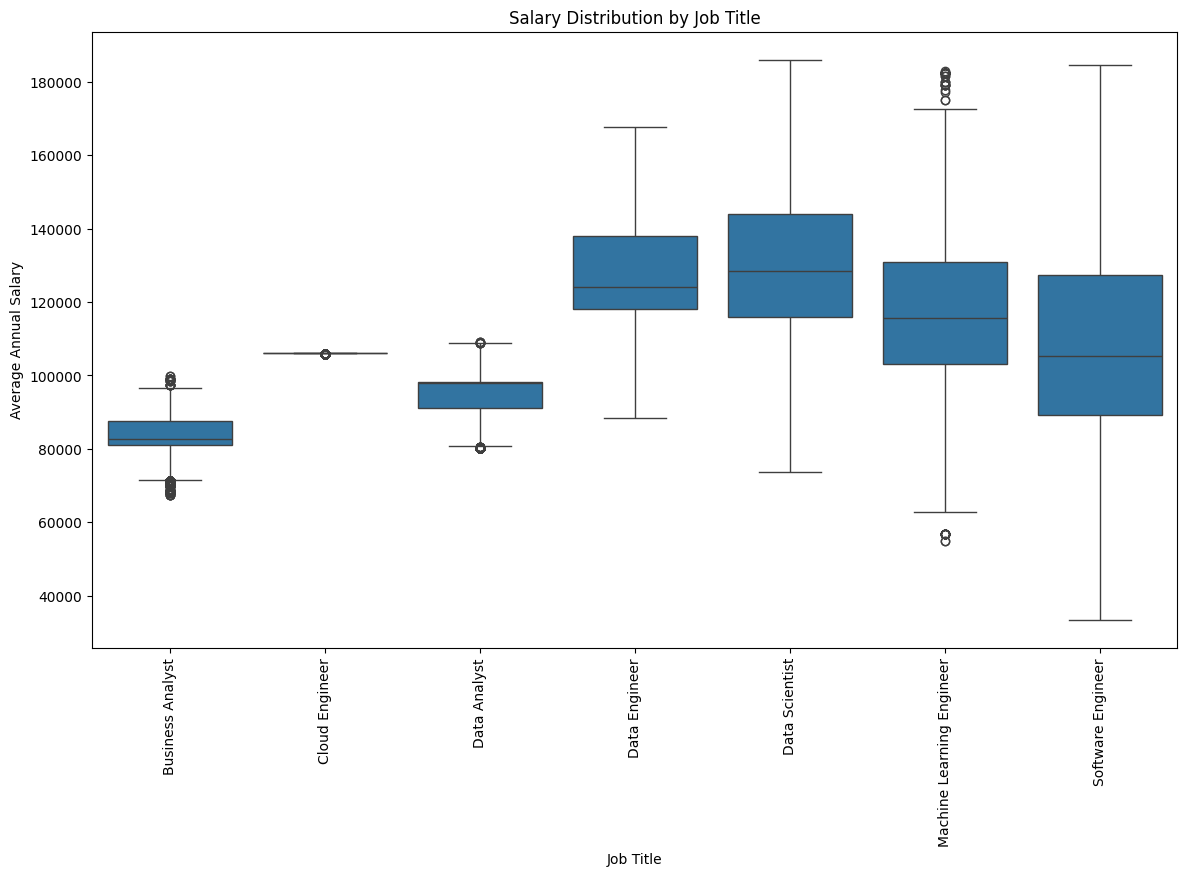

In [40]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='job_title_short', y='salary_year_avg', data=df_cleaned)
plt.xticks(rotation=90)
plt.xlabel('Job Title')
plt.ylabel('Average Annual Salary')
plt.title('Salary Distribution by Job Title')
plt.show()


In [21]:
unique_counts = df_cleaned.nunique().reset_index()

# Renaming columns for clarity
unique_counts.columns = ['Column', 'Unique_Count']

# Display the result
unique_counts

,Column,Unique_Count
0,job_title_short,7
1,job_title,221726
2,job_location,16782
3,job_via,7635
4,job_schedule_type,5
5,job_work_from_home,2
6,search_location,164
7,job_posted_date,580779
8,job_no_degree_mention,2
9,job_health_insurance,2


In [22]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs
285721,Data Engineer,Data Engineer,"New South Wales, Australia",via Jobrapido.com,Full-time,False,Australia,2023-01-30 00:23:08,False,False,Australia,114190.910256,Groupm,"['python', 'sql', 'mysql', 'sql server', 'gcp'...","{'async': ['jira', 'confluence', 'asana'], 'cl...",1
10488,Business Analyst,Reporting Analyst,Anywhere,via LinkedIn,Full-time,True,"Texas, United States",2023-12-15 22:01:16,True,False,United States,96175.447397,Dice,"['tableau', 'excel', 'powerpoint', 'sharepoint...","{'analyst_tools': ['tableau', 'excel', 'powerp...",1
715786,Software Engineer,Software Engineer,"Doha, Qatar",via BeBee دولة قطر,Full-time,False,Qatar,2023-10-11 07:34:26,True,False,Qatar,105385.004397,Canonical Qatar,['python'],{'programming': ['python']},1


In [23]:
df_cleaned['job_title_short'].value_counts().reset_index()

,job_title_short,count
0,Data Engineer,227436
1,Data Analyst,207194
2,Data Scientist,206162
3,Software Engineer,44517
4,Business Analyst,40014
5,Machine Learning Engineer,13703
6,Cloud Engineer,7387


In [24]:
df_cleaned['job_skills'].value_counts().reset_index().head(20)

,job_skills,count
0,Not specified,109357
1,['excel'],12038
2,['sql'],10968
3,['python'],8219
4,"['python', 'sql']",4591
5,"['sql', 'python']",4054
6,"['sql', 'excel']",4006
7,['sap'],3533
8,['go'],3139
9,"['python', 'r']",3035


In [25]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs
472997,Data Engineer,Data Engineer II,"Bengaluru, Karnataka, India",via BeBee India,Full-time,False,India,2023-04-14 20:33:32,False,False,India,125541.000000,AB INBEV GCC Services India Private Limited,"['no-sql', 'snowflake', 'azure', 'pyspark', 's...","{'analyst_tools': ['sap'], 'cloud': ['snowflak...",1
303110,Data Engineer,Data Engineer - Google Cloud Platform,"Mumbai, Maharashtra, India",via LinkedIn,Full-time,False,India,2023-11-24 15:11:29,False,False,India,125541.000000,CODNEXT IT,"['python', 'gcp', 'flow']","{'cloud': ['gcp'], 'other': ['flow'], 'program...",1
667545,Data Scientist,Head of Data Science (PhD),"Cambridge, MA",via LinkedIn,Full-time,False,"New York, United States",2023-11-07 02:18:29,False,False,United States,144098.450819,basys.ai,Not specified,Not specified,1


In [26]:
df_cleaned['job_skills'].unique()

array(["['excel', 'powerpoint', 'power bi']",
       "['r', 'python', 'sql', 'tableau', 'power bi']",
       "['sql', 'tableau', 'spss', 'sap']", ...,
       "['java', 'mongodb', 'mongodb', 'c++', 'python', 'c#', 'kotlin', 'postgresql', 'redis', 'aws', 'spring', 'git', 'github', 'kubernetes']",
       "['c++', 'aws']",
       "['bash', 'python', 'perl', 'linux', 'unix', 'kubernetes', 'docker', 'ansible']"],
      dtype=object)

In [27]:
# Display the DataFrame with the new num_jobs column
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs
727455,Software Engineer,IT Support Analyst,Hong Kong,via Trabajo.org - Job Search - Jobs,Full-time,False,Hong Kong,2023-07-14 16:28:01,False,False,Hong Kong,105385.004397,Phoenix Property Investors (HK) Limited,"['azure', 'vmware', 'phoenix', 'windows', 'sha...","{'analyst_tools': ['sharepoint'], 'cloud': ['a...",1
546769,Data Scientist,Data Scientist – Remote – up to R500 per Hour,"Johannesburg, South Africa",via BeBee South Africa,Full-time,False,South Africa,2023-04-06 07:27:56,False,False,South Africa,138574.608696,E-Merge,"['python', 'sql', 'azure']","{'cloud': ['azure'], 'programming': ['python',...",1
348801,Data Engineer,Finance Transformation Program – IT Data Engin...,"New Delhi, Delhi, India",via Jobsally.me,Full-time,False,India,2023-06-27 23:34:52,False,False,India,125541.000000,Boston Consulting Group,"['sql', 'python', 'scala', 'java', 'mysql', 's...","{'analyst_tools': ['sap', 'qlik'], 'cloud': ['...",1


In [28]:
df_cleaned.job_location.value_counts()

job_location
Anywhere                       67326
Singapore                      22994
Paris, France                  12267
Bengaluru, Karnataka, India    11410
London, UK                     10491
                               ...  
Oosterwolde, Netherlands           1
Mollis, Switzerland                1
Baillargues, France                1
Cumberland, RI                     1
San Juan, Puerto Riko              1
Name: count, Length: 16782, dtype: int64

In [29]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746413 entries, 0 to 746412
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   job_title_short        746413 non-null  object 
 1   job_title              746413 non-null  object 
 2   job_location           746413 non-null  object 
 3   job_via                746413 non-null  object 
 4   job_schedule_type      746413 non-null  object 
 5   job_work_from_home     746413 non-null  bool   
 6   search_location        746413 non-null  object 
 7   job_posted_date        746413 non-null  object 
 8   job_no_degree_mention  746413 non-null  bool   
 9   job_health_insurance   746413 non-null  bool   
 10  job_country            746413 non-null  object 
 11  salary_year_avg        746413 non-null  float64
 12  company_name           746413 non-null  object 
 13  job_skills             746413 non-null  object 
 14  job_type_skills        746413 non-nu

In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import concurrent.futures

# Initialize cache
cache = {}

def dms_to_decimal(dms_str):
    """Convert DMS (Degrees, Minutes, Seconds) to Decimal degrees."""
    match = re.match(r'([NSWE])\s*(\d+)[°\s]+(\d+)[′\s]+(\d+(\.\d+)?)[″\s]*', dms_str)
    if not match:
        return None
    direction, degrees, minutes, seconds, _ = match.groups()
    degrees = float(degrees)
    minutes = float(minutes)
    seconds = float(seconds)
    decimal = degrees + (minutes / 60) + (seconds / 3600)
    if direction in ['S', 'W']:
        decimal *= -1
    return decimal

def get_country_gps(country_name):
    """Fetch GPS coordinates for a given country, using cache to avoid redundant requests."""
    if country_name in cache:
        return cache[country_name]

    try:
        url = f'http://www.geonames.org/search.html?q={country_name}&country='
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            table = soup.find('table', class_='restable')
            if table:
                rows = table.find_all('tr')
                for row in rows[1:]:
                    cols = row.find_all('td')
                    if len(cols) >= 6:
                        latitude_dms = cols[4].text.strip()
                        longitude_dms = cols[5].text.strip()
                        latitude = dms_to_decimal(latitude_dms)
                        longitude = dms_to_decimal(longitude_dms)
                        result = (latitude, longitude)
                        cache[country_name] = result
                        return result

            cache[country_name] = (None, None)
            return None, None
        else:
            cache[country_name] = (None, None)
            return None, None
    except Exception as e:
        cache[country_name] = (None, None)
        return None, None

def fetch_country_data(countries):
    """Fetch GPS data for a list of countries in parallel."""
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(get_country_gps, countries))
    return dict(zip(countries, results))

# Assuming you have a DataFrame df_cleaned with a 'job_country' column
unique_countries = df_cleaned['job_country'].unique()

# Fetch GPS data for all unique countries
country_coords = fetch_country_data(unique_countries)

# Apply the cached results to the DataFrame
df_cleaned[['latitude', 'longitude']] = df_cleaned['job_country'].apply(lambda country: pd.Series(country_coords.get(country, (None, None))))




In [31]:
# Output the DataFrame with the new columns
df_cleaned.head(5)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs,latitude,longitude
0,Business Analyst,Technology & Operations Business Analyst,"Copenhagen, Denmark",via Trabajo.org,Full-time,False,Denmark,2023-06-05 13:44:34,False,False,Denmark,82713.814575,Hempel,"['excel', 'powerpoint', 'power bi']","{'analyst_tools': ['excel', 'powerpoint', 'pow...",1,56.000000,10.000000
1,Business Analyst,Business Intelligence Intern,"Dallas, TX",via LinkedIn,Full-time,False,"Texas, United States",2023-01-04 13:02:07,False,False,United States,96175.447397,Copart,"['r', 'python', 'sql', 'tableau', 'power bi']","{'analyst_tools': ['tableau', 'power bi'], 'pr...",1,-14.604722,-57.656111
2,Business Analyst,Commercial Analyst,South Africa,via LinkedIn,Full-time,False,South Africa,2023-02-14 13:36:23,True,False,South Africa,87050.000000,PEP,"['sql', 'tableau', 'spss', 'sap']","{'analyst_tools': ['tableau', 'spss', 'sap'], ...",1,-29.000000,24.000000
3,Business Analyst,Procurement Analyst,"Villa Park, IL",via ZipRecruiter,Full-time,False,"Illinois, United States",2023-08-27 13:02:11,False,False,United States,96175.447397,"Sara Lee Frozen Bakery,LLC","['excel', 'powerpoint']","{'analyst_tools': ['excel', 'powerpoint']}",1,-14.604722,-57.656111
4,Business Analyst,Senior Management Analyst,"San Antonio, TX",via Trabajo.org,Full-time,False,"Texas, United States",2023-10-29 13:01:08,False,False,United States,96175.447397,City of San Antonio Texas,['c'],{'programming': ['c']},1,-14.604722,-57.656111


In [32]:
df_cleaned.job_country.nunique()

159

In [33]:
# Check if any latitude and longitude pairs are duplicated
coordinate_pairs = df_cleaned[['latitude', 'longitude']].drop_duplicates()
print("Unique coordinate pairs count:", len(coordinate_pairs))


Unique coordinate pairs count: 159


In [34]:
# Check for countries that did not get geocoded
missing_countries = df_cleaned[df_cleaned[['latitude', 'longitude']].isna().any(axis=1)]['job_country'].unique()
print("Countries with missing coordinates:", missing_countries)

# Check for discrepancies between unique country names and coordinates
unique_countries = df_cleaned['job_country'].unique()
unique_latitudes = df_cleaned['latitude'].dropna().unique()
unique_longitudes = df_cleaned['longitude'].dropna().unique()

print("Unique countries count:", len(unique_countries))
print("Unique latitudes count:", len(unique_latitudes))
print("Unique longitudes count:", len(unique_longitudes))


Countries with missing coordinates: []
Unique countries count: 159
Unique latitudes count: 132
Unique longitudes count: 139


In [35]:
# Sample inspection of rows
df_cleaned[['job_country', 'latitude', 'longitude']].head(10)


,job_country,latitude,longitude
0,Denmark,56.000000,10.000000
1,United States,-14.604722,-57.656111
2,South Africa,-29.000000,24.000000
3,United States,-14.604722,-57.656111
4,United States,-14.604722,-57.656111
5,Mauritius,-20.300000,57.583333
6,Chile,-30.000000,-71.000000
7,Germany,51.500000,10.500000
8,Belgium,50.750000,4.500000
9,Sudan,16.000000,30.000000


In [36]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs,latitude,longitude
281397,Data Engineer,Data Engineer H/F,"Île-de-France, France",via Recruit.net,Full-time,False,France,2023-09-18 00:21:18,False,False,France,119621.266234,Meritis,"['scala', 'python', 'sql', 'java', 'nosql', 'a...","{'cloud': ['aws', 'azure', 'oracle', 'gcp'], '...",1,46.000000,2.000000
268803,Data Engineer,Big Data Engineer Job Ref #: 981496,"Atlanta, GA",via DE Jobs,Full-time,False,"Illinois, United States",2023-10-21 06:07:45,False,False,United States,138812.678396,Concentrix,"['mysql', 'jquery']","{'databases': ['mysql'], 'webframeworks': ['jq...",1,-14.604722,-57.656111
522871,Data Scientist,"Software Engineer, Data Science","Corona, CA",via BeBee,Full-time,False,"California, United States",2023-11-21 08:03:51,False,True,United States,144098.450819,"QTC Management, Inc.","['c#', 'javascript', 'sql', 'c', 'sql server',...","{'cloud': ['oracle'], 'databases': ['sql serve...",1,-14.604722,-57.656111


In [37]:
# Save the DataFrame to a CSV file in the 'Data/output' folder
df_cleaned.to_csv('Data/output/df_cleaned.csv', index=False)

In [38]:
df_cleaned.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_year_avg,company_name,job_skills,job_type_skills,num_jobs,latitude,longitude
290692,Data Engineer,Senior Data Engineer,"Bristol, UK",via BeBee,Full-time,False,United Kingdom,2023-10-28 08:13:00,True,False,United Kingdom,121887.291667,Vertical Aerospace Ltd,['gdpr'],{'libraries': ['gdpr']},1,54.758333,-2.695278
266752,Data Engineer,Data Engineer,Denmark,via LinkedIn,Full-time,False,Denmark,2023-11-20 06:29:05,False,False,Denmark,134818.250000,DK Company A/S,"['sql', 'python', 't-sql', 'sql server', 'azur...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",1,56.000000,10.000000
84053,Data Analyst,Business Data Analyst als Berater IT Systeme,"Düsseldorf, Germany",via BeBee,Full-time,False,Germany,2023-10-07 08:12:13,True,False,Germany,101085.380952,rolfes.schierenbeckates gmbh,"['python', 'sql', 'azure']","{'cloud': ['azure'], 'programming': ['python',...",1,51.500000,10.500000


In [39]:
df_cleaned.isnull().sum()

job_title_short          0
job_title                0
job_location             0
job_via                  0
job_schedule_type        0
job_work_from_home       0
search_location          0
job_posted_date          0
job_no_degree_mention    0
job_health_insurance     0
job_country              0
salary_year_avg          0
company_name             0
job_skills               0
job_type_skills          0
num_jobs                 0
latitude                 0
longitude                0
dtype: int64